In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import json

In [ ]:
# Load dataset
def load_data(train_file, test_file):
    with open(train_file, 'r') as f:
        train_data = json.load(f)
    with open(test_file, 'r') as f:
        test_data = json.load(f)

    X_train = np.array([item['features'] for item in train_data])
    y_train = np.array([item['label'] for item in train_data])
    X_test = np.array([item['features'] for item in test_data])
    y_test = np.array([item['label'] for item in test_data])

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = load_data('gaussian_trainset.json', 'gaussian_testset.json')

In [ ]:
# Plot Gaussian distribution
def plot_gaussian_distribution(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.7)
    plt.xlabel('Feature_1')
    plt.ylabel('Feature_2')
    plt.show()

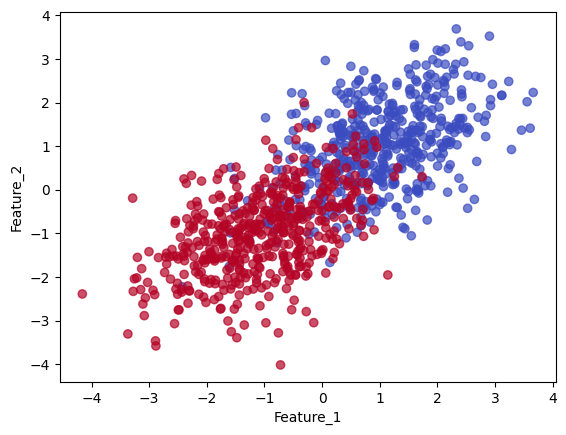

In [ ]:
# Trainset distribution
plot_gaussian_distribution(X_train, y_train)

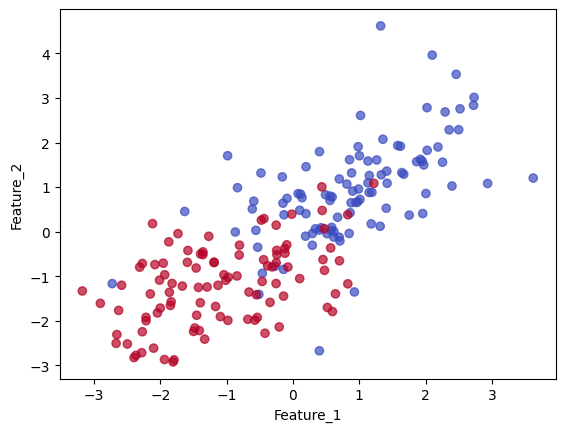

In [ ]:
# Testset distribution
plot_gaussian_distribution(X_test, y_test)

In [ ]:
# Standardization of Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Design Neural Network
# 1. Gradient Descent
class NeuralNetwork_GD:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, l1_lambda=0.0, l2_lambda=0.0):
        self.weights = []
        self.biases = []
        self.weights.append(np.random.randn(input_size, hidden_sizes[0]) * 0.01)
        self.biases.append(np.zeros((1, hidden_sizes[0])))

        for i in range(1, len(hidden_sizes)):
            self.weights.append(np.random.randn(hidden_sizes[i-1], hidden_sizes[i]) * 0.01)
            self.biases.append(np.zeros((1, hidden_sizes[i])))

        self.learning_rate = learning_rate
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.weights.append(np.random.randn(hidden_sizes[-1], output_size) * 0.01)
        self.biases.append(np.zeros((1, output_size)))

    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))
    def sigmoid_derivative(self, z):
        return z*(1 - z)

    def relu(self, z):
        return np.maximum(0, z)
    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def linear(self, z):
        return z

    def forward(self, X):
        self.activations = [X]
        for i in range(len(self.weights)-1):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            A = self.relu(Z)
            self.activations.append(A)

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        A = self.sigmoid(Z)
        self.activations.append(A)
        return A

    def forward_linear(self, X):
        self.activations = [X]
        for i in range(len(self.weights) - 1):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            A = self.linear(Z)
            self.activations.append(A)

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        A = self.linear(Z)
        self.activations.append(A)
        return A

    def backward(self, X, y):
        m = X.shape[0]
        dZ = self.activations[-1] - y.reshape(-1, 1)
        dW = (1/m) * np.dot(self.activations[-2].T, dZ)
        db = (1/m) * np.sum(dZ, axis=0, keepdims=True)
        self.weights[-1] -= self.learning_rate * dW
        self.biases[-1] -= self.learning_rate * db

        for i in reversed(range(len(self.weights) - 1)):
            dA = np.dot(dZ, self.weights[i + 1].T)
            dZ = dA * self.relu_derivative(self.activations[i + 1])
            dW = (1/m) * np.dot(self.activations[i].T, dZ)
            db = (1/m) * np.sum(dZ, axis=0, keepdims=True)
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

    def backward_linear(self, X, y):
        m = X.shape[0]
        dZ = self.activations[-1] - y.reshape(-1, 1)
        dW = (1/m) * np.dot(self.activations[-2].T, dZ)
        db = (1/m) * np.sum(dZ, axis=0, keepdims=True)
        self.weights[-1] -= self.learning_rate * dW
        self.biases[-1] -= self.learning_rate * db

        for i in reversed(range(len(self.weights) - 1)):
            dA = np.dot(dZ, self.weights[i + 1].T)
            dZ = dA
            dW = (1/m) * np.dot(self.activations[i].T, dZ)
            db = (1/m) * np.sum(dZ, axis=0, keepdims=True)
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

    def cal_loss(self, y, output):
        loss = -np.mean(y * np.log(output) + (1 - y) * np.log(1 - output))
        return loss

    def cal_loss_regularization(self, y, output):
        bce_loss = -np.mean(y * np.log(output) + (1 - y) * np.log(1 - output))
        l1_loss = self.l1_lambda * sum(np.sum(np.abs(w)) for w in self.weights)
        l2_loss = self.l2_lambda * sum(np.sum(np.square(w)) for w in self.weights)
        loss = bce_loss + l1_loss + l2_loss
        return loss

    def cal_loss_linear(self, y, output):
        loss = np.mean((y - output) ** 2)
        return loss

    def train(self, X, y, iterations):
        for i in range(iterations):
            output = self.forward(X)
            if i % 1000 == 0:
                loss = self.cal_loss(y, output)
                print(f"Iteration: {i}, Loss: {loss:.4f}")
            self.backward(X, y)

    def train_regularization(self, X, y, iterations):
        for i in range(iterations):
            output = self.forward(X)
            if i % 1000 == 0:
                loss = self.cal_loss_regularization(y, output)
                print(f"Iteration: {i}, Loss: {loss:.4f}")
            self.backward(X, y)

    def train_linear(self, X, y, iterations):
        for i in range(iterations):
            output = self.forward_linear(X)
            if i % 1000 == 0:
                loss = self.cal_loss_linear(y, output)
                print(f"Iteration: {i}, Loss: {loss:.4f}")
            self.backward_linear(X, y)

    def predict(self, X):
        output = self.forward(X)
        predictions = (output > 0.5).astype(int)
        return predictions

    def predict_linear(self, X):
        output = self.forward_linear(X)
        predictions = (output > 0.5).astype(int)
        return predictions


In [ ]:
# Grid Search for Linear
def grid_search_linear(X_train, y_train, X_test, y_test):
    # Hyperparameters
    input_size = 2
    output_size = 1
    hidden_layer_options = [[1]]
    learning_rate_options = [0.001, 0.01, 0.1]
    iteration_options = [5000, 10000, 20000]

    best_accuracy = 0
    best_params = None
    best_model = None
    results = []

    print("\nRunning Grid Search for Linear Activation Model:\n")
    for hidden_sizes, learning_rate, iterations in itertools.product(hidden_layer_options, learning_rate_options, iteration_options):
        nn = NeuralNetwork_GD(input_size, hidden_sizes, output_size, learning_rate)
        nn.train_linear(X_train, y_train, iterations)

        y_pred = nn.predict_linear(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Hidden Sizes: {hidden_sizes}, Learning Rate: {learning_rate}, Iterations: {iterations}, Test Accuracy: {accuracy * 100:.2f}%")

        results.append({
            'Model': 'Linear',
            'Hidden Sizes': hidden_sizes,
            'Learning Rate': learning_rate,
            'Iterations': iterations,
            'Test Accuracy': accuracy * 100
        })

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (hidden_sizes, learning_rate, iterations)
            best_model_linear = nn

    results_df = pd.DataFrame(results)
    print("\nGrid Search Results:")
    print(results_df)

    print("\nBest Hyperparameters for Linear Activation Model:")
    print(f"Hidden Sizes: {best_params[0]}, Learning Rate: {best_params[1]}, Iterations: {best_params[2]}, Best Test Accuracy: {best_accuracy * 100:.2f}%")

    return best_model_linear

best_model_linear = grid_search_linear(X_train_scaled, y_train, X_test_scaled, y_test)


Running Grid Search for Linear Activation Model:

Iteration: 0, Loss: 0.5000
Iteration: 1000, Loss: 0.2838
Iteration: 2000, Loss: 0.2546
Iteration: 3000, Loss: 0.2506
Iteration: 4000, Loss: 0.2501
Hidden Sizes: [1], Learning Rate: 0.001, Iterations: 5000, Test Accuracy: 50.00%
Iteration: 0, Loss: 0.5000
Iteration: 1000, Loss: 0.2838
Iteration: 2000, Loss: 0.2546
Iteration: 3000, Loss: 0.2506
Iteration: 4000, Loss: 0.2501
Iteration: 5000, Loss: 0.2505
Iteration: 6000, Loss: 0.2528
Iteration: 7000, Loss: 0.2640
Iteration: 8000, Loss: 0.2950
Iteration: 9000, Loss: 0.3383
Hidden Sizes: [1], Learning Rate: 0.001, Iterations: 10000, Test Accuracy: 90.00%
Iteration: 0, Loss: 0.5000
Iteration: 1000, Loss: 0.2838
Iteration: 2000, Loss: 0.2546
Iteration: 3000, Loss: 0.2506
Iteration: 4000, Loss: 0.2502
Iteration: 5000, Loss: 0.2505
Iteration: 6000, Loss: 0.2534
Iteration: 7000, Loss: 0.2660
Iteration: 8000, Loss: 0.2989
Iteration: 9000, Loss: 0.3419
Iteration: 10000, Loss: 0.3727
Iteration: 110

In [ ]:
# 2. Momentum
class NeuralNetwork_Momentum:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, momentum=0.9):
        self.weights = []
        self.biases = []
        self.velocities_w = []  # Velocity terms for weights
        self.velocities_b = []  # Velocity terms for biases

        self.weights.append(np.random.randn(input_size, hidden_sizes[0]) * 0.01)
        self.biases.append(np.zeros((1, hidden_sizes[0])))
        self.velocities_w.append(np.zeros_like(self.weights[0]))
        self.velocities_b.append(np.zeros_like(self.biases[0]))

        for i in range(1, len(hidden_sizes)):
            self.weights.append(np.random.randn(hidden_sizes[i-1], hidden_sizes[i]) * 0.01)
            self.biases.append(np.zeros((1, hidden_sizes[i])))
            self.velocities_w.append(np.zeros_like(self.weights[i]))
            self.velocities_b.append(np.zeros_like(self.biases[i]))

        self.learning_rate = learning_rate
        self.momentum = momentum

        self.weights.append(np.random.randn(hidden_sizes[-1], output_size) * 0.01)
        self.biases.append(np.zeros((1, output_size)))
        self.velocities_w.append(np.zeros_like(self.weights[-1]))
        self.velocities_b.append(np.zeros_like(self.biases[-1]))

    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return z*(1 - z)

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        self.activations = [X]
        for i in range(len(self.weights)-1):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            A = self.relu(Z)
            self.activations.append(A)

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        A = self.sigmoid(Z)
        self.activations.append(A)
        return A

    def backward(self, X, y):
        m = X.shape[0]
        dZ = self.activations[-1] - y.reshape(-1, 1)
        dW = (1 / m) * np.dot(self.activations[-2].T, dZ)
        db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)

        self.velocities_w[-1] = self.momentum * self.velocities_w[-1] - self.learning_rate * dW
        self.velocities_b[-1] = self.momentum * self.velocities_b[-1] - self.learning_rate * db
        self.weights[-1] += self.velocities_w[-1]
        self.biases[-1] += self.velocities_b[-1]

        for i in reversed(range(len(self.weights) - 1)):
            dA = np.dot(dZ, self.weights[i + 1].T)
            dZ = dA * self.relu_derivative(self.activations[i + 1])
            dW = (1 / m) * np.dot(self.activations[i].T, dZ)
            db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)

            self.velocities_w[i] = self.momentum * self.velocities_w[i] - self.learning_rate * dW
            self.velocities_b[i] = self.momentum * self.velocities_b[i] - self.learning_rate * db
            self.weights[i] += self.velocities_w[i]
            self.biases[i] += self.velocities_b[i]

    def train(self, X, y, iterations):
        for i in range(iterations):
            output = self.forward(X)
            self.backward(X, y)
            if i % 1000 == 0:
                loss = self.cal_loss(y, output)
                print(f"Iteration {i}, Loss: {loss:.4f}")

    def cal_loss(self, y, output):
        loss = -np.mean(y * np.log(output) + (1 - y) * np.log(1 - output))
        return loss

    def predict(self, X):
        output = self.forward(X)
        predictions = (output > 0.5).astype(int)
        return predictions

In [ ]:
# 3. ADAM
class NeuralNetwork_Adam:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.weights = []
        self.biases = []
        self.m_w = []
        self.m_b = []
        self.v_w = []
        self.v_b = []
        self.t = 0

        self.weights.append(np.random.randn(input_size, hidden_sizes[0]) * 0.01)
        self.biases.append(np.zeros((1, hidden_sizes[0])))
        self.m_w.append(np.zeros_like(self.weights[0]))
        self.m_b.append(np.zeros_like(self.biases[0]))
        self.v_w.append(np.zeros_like(self.weights[0]))
        self.v_b.append(np.zeros_like(self.biases[0]))

        for i in range(1, len(hidden_sizes)):
            self.weights.append(np.random.randn(hidden_sizes[i-1], hidden_sizes[i]) * 0.01)
            self.biases.append(np.zeros((1, hidden_sizes[i])))
            self.m_w.append(np.zeros_like(self.weights[i]))
            self.m_b.append(np.zeros_like(self.biases[i]))
            self.v_w.append(np.zeros_like(self.weights[i]))
            self.v_b.append(np.zeros_like(self.biases[i]))

        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.weights.append(np.random.randn(hidden_sizes[-1], output_size) * 0.01)
        self.biases.append(np.zeros((1, output_size)))
        self.m_w.append(np.zeros_like(self.weights[-1]))
        self.m_b.append(np.zeros_like(self.biases[-1]))
        self.v_w.append(np.zeros_like(self.weights[-1]))
        self.v_b.append(np.zeros_like(self.biases[-1]))

    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return z*(1 - z)

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        self.activations = [X]
        for i in range(len(self.weights)-1):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            A = self.relu(Z)
            self.activations.append(A)

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        A = self.sigmoid(Z)
        self.activations.append(A)
        return A

    def backward(self, X, y):
        m = X.shape[0]
        self.t += 1
        dZ = self.activations[-1] - y.reshape(-1, 1)
        dW = (1 / m) * np.dot(self.activations[-2].T, dZ)
        db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)

        self.m_w[-1] = self.beta1 * self.m_w[-1] + (1 - self.beta1) * dW
        self.m_b[-1] = self.beta1 * self.m_b[-1] + (1 - self.beta1) * db
        self.v_w[-1] = self.beta2 * self.v_w[-1] + (1 - self.beta2) * (dW ** 2)
        self.v_b[-1] = self.beta2 * self.v_b[-1] + (1 - self.beta2) * (db ** 2)

        m_w_hat = self.m_w[-1] / (1 - self.beta1 ** self.t)
        m_b_hat = self.m_b[-1] / (1 - self.beta1 ** self.t)
        v_w_hat = self.v_w[-1] / (1 - self.beta2 ** self.t)
        v_b_hat = self.v_b[-1] / (1 - self.beta2 ** self.t)

        self.weights[-1] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
        self.biases[-1] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        for i in reversed(range(len(self.weights) - 1)):
            dA = np.dot(dZ, self.weights[i + 1].T)
            dZ = dA * self.relu_derivative(self.activations[i + 1])
            dW = (1 / m) * np.dot(self.activations[i].T, dZ)
            db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)

            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dW
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dW ** 2)
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db ** 2)

            m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
            m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

            self.weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

    def train(self, X, y, iterations):
        for i in range(iterations):
            output = self.forward(X)
            self.backward(X, y)
            if i % 1000 == 0:
                loss = self.cal_loss(y, output)
                print(f"Iteration {i}, Loss: {loss:.4f}")

    def cal_loss(self, y, output):
        loss = -np.mean(y * np.log(output) + (1 - y) * np.log(1 - output))
        return loss

    def predict(self, X):
        output = self.forward(X)
        predictions = (output > 0.5).astype(int)
        return predictions

In [ ]:
# Grid Search_Hyperparameters
import itertools

def grid_search(X_train, y_train, X_test, y_test):
    # Hyperparameters
    input_size = 2
    output_size = 1
    hidden_layer_options = [[2], [4], [8], [4, 4], [4, 2], [8, 4, 2]]
    learning_rate_options = [0.001, 0.01, 0.1]
    iteration_options = [5000, 10000, 20000]

    results = []

    # GD
    best_accuracy_gd = 0
    best_params_gd = None
    best_model_gd = None
    print("\nRunning Grid Search for Gradient Descent Model:\n")
    for hidden_sizes, learning_rate, iterations in itertools.product(hidden_layer_options, learning_rate_options, iteration_options):
        nn = NeuralNetwork_GD(input_size, hidden_sizes, output_size, learning_rate)
        nn.train(X_train, y_train, iterations)

        y_pred = nn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Hidden Sizes: {hidden_sizes}, Learning Rate: {learning_rate}, Iterations: {iterations}, Test Accuracy: {accuracy * 100:.2f}%")

        results.append({
            'Model': 'GD',
            'Hidden Sizes': hidden_sizes,
            'Learning Rate': learning_rate,
            'Iterations': iterations,
            'Test Accuracy': accuracy * 100
        })

        if accuracy > best_accuracy_gd:
            best_accuracy_gd = accuracy
            best_params_gd = (hidden_sizes, learning_rate, iterations)
            best_model_gd = nn

    # Momentum
    best_accuracy_momentum = 0
    best_params_momentum = None
    best_model_momentum = None
    print("\nRunning Grid Search for Momentum Model:\n")
    for hidden_sizes, learning_rate, iterations in itertools.product(hidden_layer_options, learning_rate_options, iteration_options):
        nn = NeuralNetwork_Momentum(input_size, hidden_sizes, output_size, learning_rate)
        nn.train(X_train, y_train, iterations)

        y_pred = nn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Hidden Sizes: {hidden_sizes}, Learning Rate: {learning_rate}, Iterations: {iterations}, Test Accuracy: {accuracy * 100:.2f}%")

        results.append({
            'Model': 'Momentum',
            'Hidden Sizes': hidden_sizes,
            'Learning Rate': learning_rate,
            'Iterations': iterations,
            'Test Accuracy': accuracy * 100
        })

        if accuracy > best_accuracy_momentum:
            best_accuracy_momentum = accuracy
            best_params_momentum = (hidden_sizes, learning_rate, iterations)
            best_model_momentum = nn

    # Adam
    best_accuracy_adam = 0
    best_params_adam = None
    best_model_adam = None
    print("\nRunning Grid Search for Adam Model:\n")
    for hidden_sizes, learning_rate, iterations in itertools.product(hidden_layer_options, learning_rate_options, iteration_options):
        nn = NeuralNetwork_Adam(input_size, hidden_sizes, output_size, learning_rate)
        nn.train(X_train, y_train, iterations)

        y_pred = nn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Hidden Sizes: {hidden_sizes}, Learning Rate: {learning_rate}, Iterations: {iterations}, Test Accuracy: {accuracy * 100:.2f}%")

        results.append({
            'Model': 'Adam',
            'Hidden Sizes': hidden_sizes,
            'Learning Rate': learning_rate,
            'Iterations': iterations,
            'Test Accuracy': accuracy * 100
        })

        if accuracy > best_accuracy_adam:
            best_accuracy_adam = accuracy
            best_params_adam = (hidden_sizes, learning_rate, iterations)
            best_model_adam = nn

    results_df = pd.DataFrame(results)
    print("\nGrid Search Results:")
    print(results_df)

    print("\nBest Hyperparameters for GD:")
    print(f"Hidden Sizes: {best_params_gd[0]}, Learning Rate: {best_params_gd[1]}, Iterations: {best_params_gd[2]}, Best Test Accuracy: {best_accuracy_gd * 100:.2f}%")

    print("\nBest Hyperparameters for Momentum:")
    print(f"Hidden Sizes: {best_params_momentum[0]}, Learning Rate: {best_params_momentum[1]}, Iterations: {best_params_momentum[2]}, Best Test Accuracy: {best_accuracy_momentum * 100:.2f}%")

    print("\nBest Hyperparameters for Adam:")
    print(f"Hidden Sizes: {best_params_adam[0]}, Learning Rate: {best_params_adam[1]}, Iterations: {best_params_adam[2]}, Best Test Accuracy: {best_accuracy_adam * 100:.2f}%")

    return best_model_gd, best_model_momentum, best_model_adam

In [ ]:
# Finding best models
best_model_gd, best_model_momentum, best_model_adam = grid_search(X_train_scaled, y_train, X_test_scaled, y_test)


Running Grid Search for Gradient Descent Model:

Iteration: 0, Loss: 0.6931
Iteration: 1000, Loss: 0.6931
Iteration: 2000, Loss: 0.6931
Iteration: 3000, Loss: 0.6931
Iteration: 4000, Loss: 0.6931
Hidden Sizes: [2], Learning Rate: 0.001, Iterations: 5000, Test Accuracy: 87.50%
Iteration: 0, Loss: 0.6931
Iteration: 1000, Loss: 0.6931
Iteration: 2000, Loss: 0.6931
Iteration: 3000, Loss: 0.6931
Iteration: 4000, Loss: 0.6931
Iteration: 5000, Loss: 0.6931
Iteration: 6000, Loss: 0.6931
Iteration: 7000, Loss: 0.6931
Iteration: 8000, Loss: 0.6931
Iteration: 9000, Loss: 0.6931
Hidden Sizes: [2], Learning Rate: 0.001, Iterations: 10000, Test Accuracy: 84.50%
Iteration: 0, Loss: 0.6931
Iteration: 1000, Loss: 0.6931
Iteration: 2000, Loss: 0.6931
Iteration: 3000, Loss: 0.6931
Iteration: 4000, Loss: 0.6931
Iteration: 5000, Loss: 0.6931
Iteration: 6000, Loss: 0.6931
Iteration: 7000, Loss: 0.6931
Iteration: 8000, Loss: 0.6931
Iteration: 9000, Loss: 0.6931
Iteration: 10000, Loss: 0.6931
Iteration: 1100

<ipython-input-33-6231c6488391>:40: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


Iteration 1000, Loss: 3.7622
Iteration 2000, Loss: 2.3547
Iteration 3000, Loss: 2.8302
Iteration 4000, Loss: 3.4258
Iteration 5000, Loss: 4.4812
Iteration 6000, Loss: 7.1221
Iteration 7000, Loss: 3.9125
Iteration 8000, Loss: 4.4608
Iteration 9000, Loss: 4.5541
Hidden Sizes: [8, 4, 2], Learning Rate: 0.1, Iterations: 10000, Test Accuracy: 89.00%
Iteration 0, Loss: 0.6931
Iteration 1000, Loss: 1.9264
Iteration 2000, Loss: 2.3098
Iteration 3000, Loss: 2.9491
Iteration 4000, Loss: 2.7803
Iteration 5000, Loss: 3.0492
Iteration 6000, Loss: 3.0218


<ipython-input-33-6231c6488391>:40: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


Iteration 7000, Loss: 1.6530
Iteration 8000, Loss: 0.6931
Iteration 9000, Loss: 0.6931
Iteration 10000, Loss: 0.6931
Iteration 11000, Loss: 0.6931
Iteration 12000, Loss: 0.6931
Iteration 13000, Loss: 0.6931
Iteration 14000, Loss: 0.6931
Iteration 15000, Loss: 0.6931
Iteration 16000, Loss: 0.6931
Iteration 17000, Loss: 0.6931
Iteration 18000, Loss: 0.6931
Iteration 19000, Loss: 0.6931
Hidden Sizes: [8, 4, 2], Learning Rate: 0.1, Iterations: 20000, Test Accuracy: 50.00%

Grid Search Results:
    Model Hidden Sizes  Learning Rate  Iterations  Test Accuracy
0      GD          [2]          0.001        5000           87.5
1      GD          [2]          0.001       10000           84.5
2      GD          [2]          0.001       20000           85.5
3      GD          [2]          0.010        5000           90.0
4      GD          [2]          0.010       10000           89.0
..    ...          ...            ...         ...            ...
157  Adam    [8, 4, 2]          0.010       10000 

In [ ]:
# Boundary visualization
def plot_decision_boundary(model, X, y, title='Decision Boundary'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid)
    Z = model.predict(grid_scaled)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='Pastel1')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50, alpha=0.7, linewidth=1.5)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

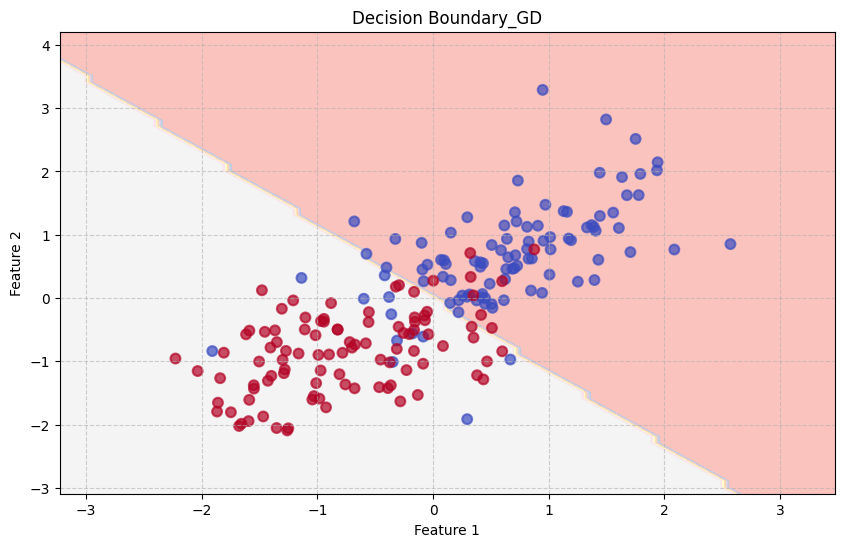

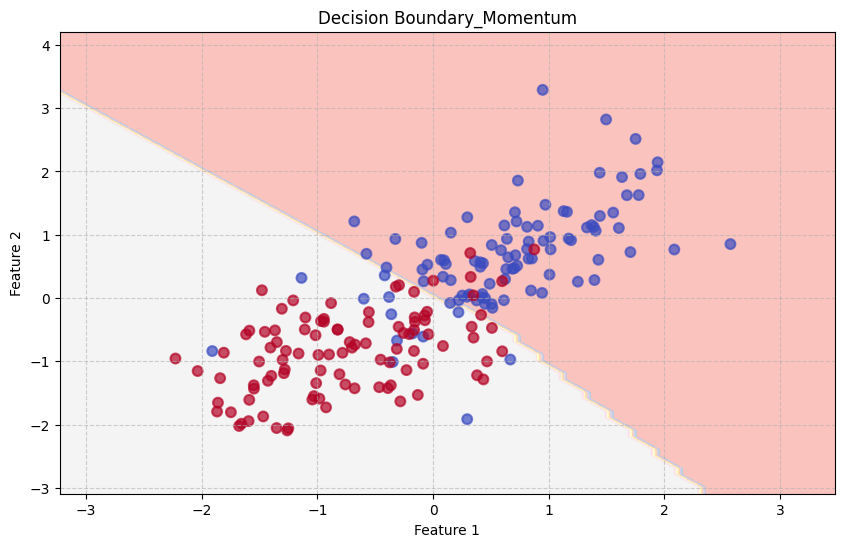

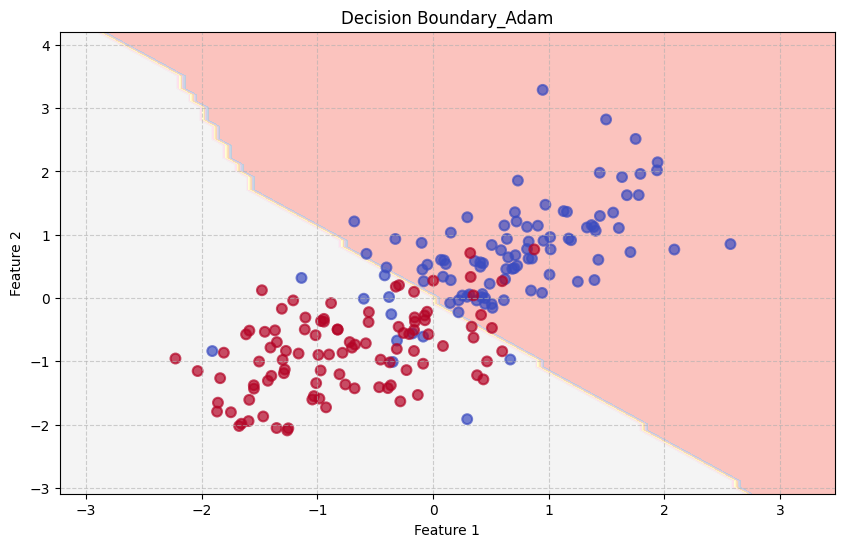

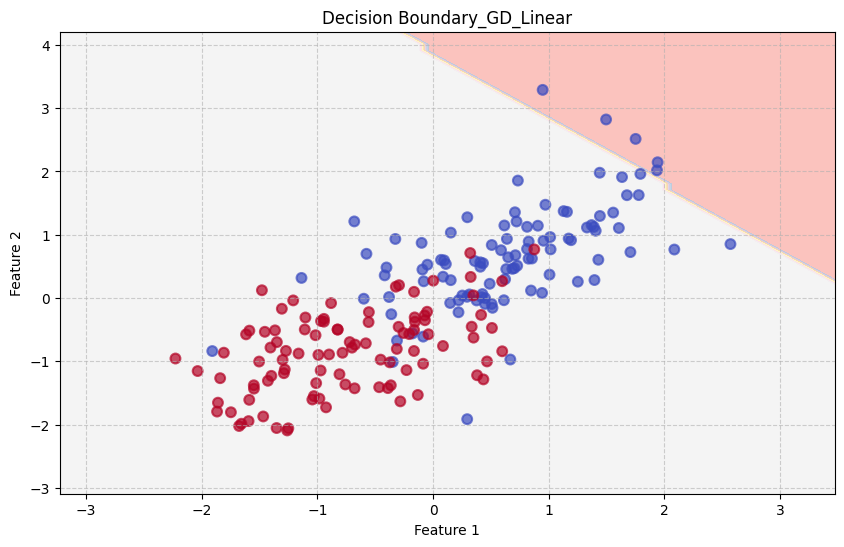

In [ ]:
# Plot decision boundary
plot_decision_boundary(best_model_gd, X_test_scaled, y_test, title='Decision Boundary_GD')
plot_decision_boundary(best_model_momentum, X_test_scaled, y_test, title='Decision Boundary_Momentum')
plot_decision_boundary(best_model_adam, X_test_scaled, y_test, title='Decision Boundary_Adam')
plot_decision_boundary(best_model_linear, X_test_scaled, y_test, title='Decision Boundary_GD_Linear')

In [ ]:
def grid_search_regularization(X_train, y_train, X_test, y_test):
    # Hyperparameters
    input_size = 2
    output_size = 1
    hidden_layer_options = [[2], [4]]
    learning_rate_options = [0.001, 0.01]
    iteration_options = [5000, 10000]
    l1_lambda_options = [0.0, 0.001, 0.01]
    l2_lambda_options = [0.0, 0.001, 0.01]

    best_accuracy = 0
    best_params = None
    best_model = None
    results = []

    print("\nRunning Grid Search for Regularization:\n")
    for hidden_sizes, learning_rate, iterations, l1_lambda, l2_lambda in itertools.product(
            hidden_layer_options, learning_rate_options, iteration_options, l1_lambda_options, l2_lambda_options):
        nn = NeuralNetwork_GD(input_size, hidden_sizes, output_size, learning_rate, l1_lambda, l2_lambda)
        nn.train_regularization(X_train, y_train, iterations)

        y_pred = nn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Hidden Sizes: {hidden_sizes}, Learning Rate: {learning_rate}, Iterations: {iterations}, L1 Lambda: {l1_lambda}, L2 Lambda: {l2_lambda}, Test Accuracy: {accuracy * 100:.2f}%")

        results.append({
            'Hidden Sizes': hidden_sizes,
            'Learning Rate': learning_rate,
            'Iterations': iterations,
            'L1 Lambda': l1_lambda,
            'L2 Lambda': l2_lambda,
            'Test Accuracy': accuracy * 100
        })

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (hidden_sizes, learning_rate, iterations, l1_lambda, l2_lambda)
            best_model_regularized = nn

    results_df = pd.DataFrame(results)
    print("\nGrid Search Results:")
    print(results_df)

    print("\nBest Hyperparameters for Regularization:")
    print(f"Hidden Sizes: {best_params[0]}, Learning Rate: {best_params[1]}, Iterations: {best_params[2]}, L1 Lambda: {best_params[3]}, L2 Lambda: {best_params[4]}, Best Test Accuracy: {best_accuracy * 100:.2f}%")

    return best_model_regularized

best_model_regularized = grid_search_regularization(X_train_scaled, y_train, X_test_scaled, y_test)



Running Grid Search for Regularization:

Iteration: 0, Loss: 0.6931
Iteration: 1000, Loss: 0.6931
Iteration: 2000, Loss: 0.6931
Iteration: 3000, Loss: 0.6931
Iteration: 4000, Loss: 0.6931
Hidden Sizes: [2], Learning Rate: 0.001, Iterations: 5000, L1 Lambda: 0.0, L2 Lambda: 0.0, Test Accuracy: 90.00%
Iteration: 0, Loss: 0.6931
Iteration: 1000, Loss: 0.6931
Iteration: 2000, Loss: 0.6931
Iteration: 3000, Loss: 0.6932
Iteration: 4000, Loss: 0.6932
Hidden Sizes: [2], Learning Rate: 0.001, Iterations: 5000, L1 Lambda: 0.0, L2 Lambda: 0.001, Test Accuracy: 87.50%
Iteration: 0, Loss: 0.6932
Iteration: 1000, Loss: 0.6932
Iteration: 2000, Loss: 0.6932
Iteration: 3000, Loss: 0.6932
Iteration: 4000, Loss: 0.6932
Hidden Sizes: [2], Learning Rate: 0.001, Iterations: 5000, L1 Lambda: 0.0, L2 Lambda: 0.01, Test Accuracy: 87.00%
Iteration: 0, Loss: 0.6932
Iteration: 1000, Loss: 0.6932
Iteration: 2000, Loss: 0.6932
Iteration: 3000, Loss: 0.6932
Iteration: 4000, Loss: 0.6932
Hidden Sizes: [2], Learning 

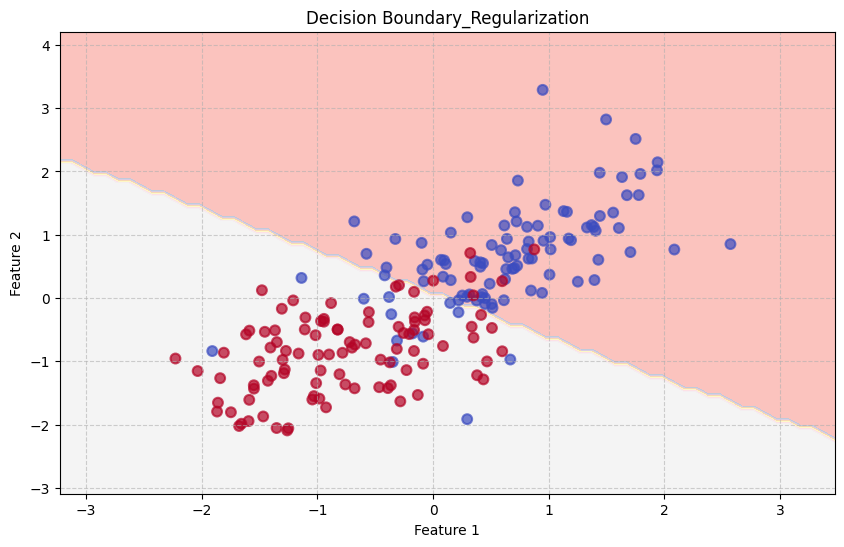

In [ ]:
plot_decision_boundary(best_model_regularized, X_test_scaled, y_test, title='Decision Boundary_Regularization')